In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pickle

import sys
from os.path import isfile, join
sys.path.insert(0, join(os.getcwd(),os.pardir))

from recipe_gen.pairing_utils import PairingData
from KitcheNette_master.unk_pairs_gen import getMainIngr

In [23]:
plt.rc("savefig", dpi=400)

In [3]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\cuisine_classification"
FILES = ["cleaned_data.pkl","full_data.pkl"]

known_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","data","kitchenette_pairing_scores.csv")
unk_path = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","prediction_unknowns_kitchenette_pretrained.mdl.csv")
pairing_pickle = os.path.join(os.getcwd(),os.pardir,"KitcheNette_master","results","full_pairings.pkl")

In [4]:
df_train = pd.read_pickle(os.path.join(FOLDER_PATH, FILES[1]))
    
df_train.columns

Index(['cuisine', 'ingredients', 'all_ingredients'], dtype='object')

In [5]:
df_train["nb_ingrs"]=[len(x) for x in df_train["ingredients"]]

In [6]:
pairing = PairingData([unk_path,known_path], pickle_file=pairing_pickle, min_score=-1,trim=False)

{'stock'}
693 pairs in total above score -1
30569 pair(s) not added because of an absent ingredient in the vocab or false ingredient
{'erythritol', 'stock', 'cloth', 'glue', 'stick', 'glycerin', 'jar'}
789 pairs in total above score -1
2892 pair(s) not added because of an absent ingredient in the vocab or false ingredient


In [7]:
len(pairing)

789

In [8]:
VOCAB_PATH = os.path.join(os.getcwd(),os.pardir,"recipe_1m_analysis", "data") 
with open(os.path.join(VOCAB_PATH, "recipe1m_vocab_ingrs.pkl"), 'rb') as f:
        vocab_ingrs = pickle.load(f)
        
vocab_main_ingr = getMainIngr(vocab_ingrs)
print(len(vocab_main_ingr),len(vocab_ingrs))


915 915


In [9]:
vocab_ingrs.delete_word("tawny_port")

In [10]:
vocab_main_ingr.word2idx["tawny_port"]

681

In [11]:
"tawny_port" in pairing.pairedIngr

False

In [14]:
to_add = []
count_err = 0
for index, recipe in df_train.iterrows():
    score = 0
    nb=0
    for i,ingr1 in enumerate(recipe["ingredients"]):
        for ingr2 in recipe["ingredients"][i+1:]:
            try:
                score += pairing.pairing_scores[pairing.pairedIngr[ingr1]][pairing.pairedIngr[ingr2]][0]
                nb+=1
                
            except KeyError:
                pass

    try:
        to_add.append(score/nb)
    except ZeroDivisionError:
        to_add.append(0)
        
df_train["recipe_score"] = to_add
print(count_err)

0


In [15]:
df_train["recipe_score"].mean()  

-0.10860046202249288

In [16]:
df_train[["cuisine","recipe_score"]][df_train["recipe_score"]!=0].groupby(["cuisine"]).mean().sort_values(by="recipe_score")

,recipe_score
cuisine,
SouthernEuropean,-0.131352
WesternEuropean,-0.119365
Asian,-0.116242
LatinAmerican,-0.115338
NorthAmerican,-0.114663
EasternEuropean,-0.111993
SoutheastAsian,-0.110110
NorthernEuropean,-0.101616
MiddleEastern,-0.096617


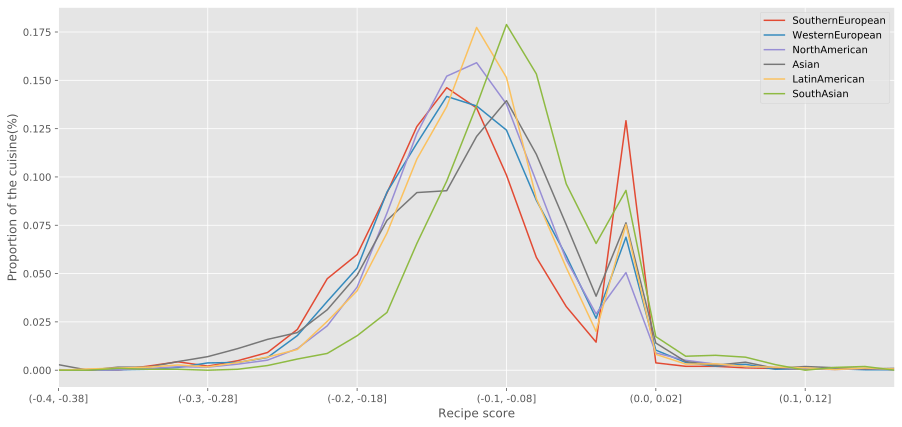

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[:6]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")
plt.savefig("F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Thesis figures\\recipe_score1.png")

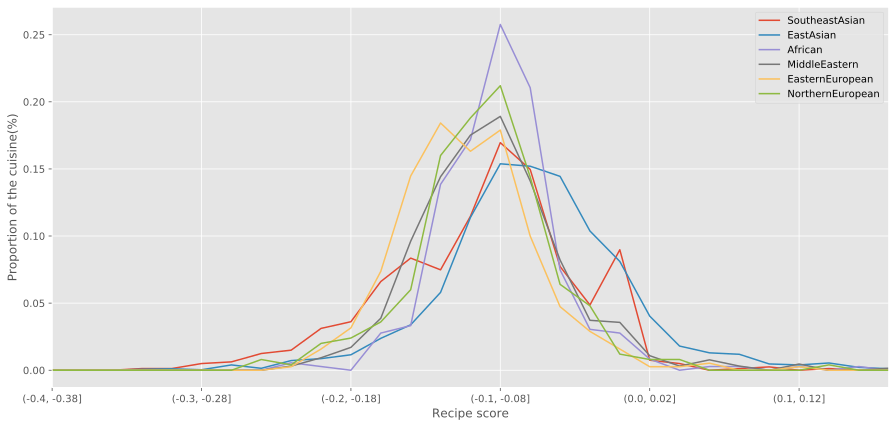

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,7))

nb_bins = 30
leg = []
for cuis in df_train.cuisine.unique()[6:]:
#cuis = "Asian"

    df = df_train[df_train["cuisine"]==cuis]
    bins = pd.cut(df['recipe_score'], [-0.4+x * 0.6/nb_bins for x in range(0, nb_bins)])
    data = df.groupby(bins).agg(['count'])[["recipe_score"]]
    data = data/data.sum()
    data.columns = data.columns.droplevel()
    data.plot(y="count",ax=ax)#,xticks=[-1+x * 2/nb_bins for x in range(0, nb_bins)]);
    leg.append(cuis)
    
ax.legend(leg)
ax.set_xlabel("Recipe score")
ax.set_ylabel("Proportion of the cuisine(%)")
plt.savefig("F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Thesis figures\\recipe_score2.png")

In [19]:
df_train[(df_train["recipe_score"]==0) & (df_train["nb_ingrs"]>1)].groupby(["cuisine"]).count()

,ingredients,all_ingredients,nb_ingrs,recipe_score
cuisine,,,,
African,1,1,1,1
Asian,169,169,169,169
EastAsian,35,35,35,35
EasternEuropean,1,1,1,1
LatinAmerican,406,406,406,406
NorthAmerican,1608,1608,1608,1608
SouthAsian,119,119,119,119
SoutheastAsian,59,59,59,59
SouthernEuropean,1060,1060,1060,1060


In [20]:
len(df_train)

84029